<a href="https://colab.research.google.com/github/mezaga/ACIML/blob/aciml-06%2F10%2F22/ACIML_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [317]:
#@title Carga de Librerias

from sklearn.preprocessing import StandardScaler
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras import layers
from keras.models import Model
from keras import backend as K
from sklearn.decomposition import  PCA
from mpl_toolkits.mplot3d import Axes3D
import IPython
import pickle
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual


In [348]:
#@title Carga de archivos
from google.colab import files
synth_names = ['am','fm','waveshapping', 'res', 'grain']
AUDIO_LOAD = []
sr16k = 16000
secs = 1

uploaded = files.upload()

for name in synth_names:
  for idx, track in enumerate(uploaded.keys()):
    if track.startswith(name) and track.endswith("wav"):
      SR = librosa.get_samplerate(track)
      y, fs = librosa.load(track, SR)
      data = librosa.resample(y[:SR * secs], orig_sr= SR, target_sr= sr16k)
      ##features (tenemos que arreglar el fft apara que sean valores de amp)
      fft = np.abs(librosa.stft(data))
      f0 = np.mean(librosa.yin(data, 30, 2093, sr= sr16k, frame_length= 2048, win_length= 1024))
    #takes only 1 sec and resample to 16k 
      AUDIO_LOAD.append({'synth': name , 'data': data, 'fft': fft, 'f0': f0})

##dataframe ordenado que contiene el tipo de sintesis y datos
DATA = pd.DataFrame(AUDIO_LOAD)
DATA.sort_values(['synth'], ignore_index= True)

print('User uploaded file "{name}" with length {length} bytes'.format(
      name= track, length=len(uploaded[track])))


Saving fm_0.wav to fm_0 (4).wav
Saving fm_1.wav to fm_1 (4).wav
Saving fm_2.wav to fm_2 (4).wav
Saving fm_3.wav to fm_3 (3).wav
Saving fm_4.wav to fm_4 (3).wav
Saving fm_5.wav to fm_5 (2).wav
Saving fm_6.wav to fm_6 (2).wav
Saving fm_7.wav to fm_7 (2).wav
Saving fm_8.wav to fm_8 (2).wav
Saving fm_9.wav to fm_9 (2).wav
Saving fm_10.wav to fm_10 (2).wav
Saving fm_11.wav to fm_11 (1).wav
Saving fm_12.wav to fm_12 (1).wav
Saving fm_13.wav to fm_13 (1).wav
Saving fm_14.wav to fm_14 (1).wav
Saving fm_15.wav to fm_15 (1).wav
Saving fm_16.wav to fm_16 (1).wav
Saving fm_17.wav to fm_17 (1).wav
Saving fm_18.wav to fm_18 (1).wav
Saving fm_19.wav to fm_19 (1).wav
Saving fm_20.wav to fm_20 (1).wav
Saving fm_21.wav to fm_21 (1).wav
Saving fm_22.wav to fm_22 (1).wav
Saving fm_23.wav to fm_23 (1).wav
Saving fm_24.wav to fm_24 (1).wav
Saving fm_25.wav to fm_25 (1).wav
Saving fm_26.wav to fm_26 (1).wav
Saving fm_27.wav to fm_27 (1).wav
Saving fm_28.wav to fm_28 (1).wav
Saving fm_29.wav to fm_29 (1).wav


In [349]:
DATA

,synth,data,fft,f0
0,fm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[1.9569726, 1.0313575, 0.052846853, 3.9973223...",2046.747629
1,fm,"[0.004135562, 0.014386324, 0.013820173, 0.0033...","[[0.031439066, 0.015683154, 7.08784e-05, 6.245...",2285.714286
2,fm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.22422291, 0.11858162, 0.0063518207, 0.0002...",193.033735
3,fm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.010608775, 0.005561308, 0.00022830852, 6.1...",1707.857958
4,fm,"[-0.027093459, -0.037971057, -0.020740047, -0....","[[0.2709986, 0.13554005, 0.00010434563, 0.0001...",625.950111
...,...,...,...,...
95,fm,"[-0.08733814, -0.1473971, -0.12501833, -0.1262...","[[0.1583887, 0.07846328, 0.015285463, 0.022303...",532.550865
96,fm,"[-0.043987397, -0.2338246, -0.32967177, -0.241...","[[0.96594036, 0.48415524, 0.00040655388, 0.000...",1538.188360
97,fm,"[0.0054011634, 0.0089495, 0.0065897573, 0.0052...","[[0.0034588866, 0.0016958407, 0.00031928922, 0...",915.130278
98,fm,"[0.390664, 0.65549123, 0.5492139, 0.5959362, 0...","[[0.91309464, 0.45514873, 0.0018264077, 0.0050...",183.287859


In [350]:
#@title Filtrado
### se debe arreglar que se puede subir de todas las tecnicas de sintesis y al mismo
### si se omite alguna que no genere error

count = np.array(DATA['synth'].value_counts())
am_data = widgets.IntSlider(value = count[0], max= count[0], step = 1, description='am data')
fm_data = widgets.IntSlider(value = count[1], max= count[1], description= 'fm data')
#c = widgets.IntSlider(value = count[0], max= count[0], description='b')
ui = widgets.VBox([am_data, fm_data])

def f(a, b):
  df = DATA.iloc[0: am_data.value]
  df_2 = DATA.iloc[count[0]: fm_data.value + count[0]]
  #df_3 = DATA.iloc[b: c]
  DATA_filt = pd.concat([df, df_2])
  #print(type(DATA_filt))
  print(DATA_filt['synth'])
  return DATA_filt

out = widgets.interactive_output(f, {'a': am_data, 'b': fm_data})

display(ui, out)

IndexError: ignored

In [340]:
#@title DATASET

df = DATA.iloc[0: am_data.value]
df_2 = DATA.iloc[count[0]: fm_data.value + count[0]]
#df_3 = DATA.iloc[b: c]
DATA_filt = pd.concat([df, df_2])
DATA_filt

,synth,data,fft,f0
0,am,"[-0.013462398, -0.022104243, -0.018687122, -0....","[[1.2149388, 0.8591632, 0.12988582, 0.24544008...",52.598838
1,am,"[-0.18287453, -0.28812802, -0.22628835, -0.228...","[[21.875696, 10.924467, 0.03551808, 0.00154266...",115.758752
2,am,"[-0.002188103, -0.0007318296, 0.0036004044, 0....","[[1.8109988, 0.9094406, 1.6220957, 5.0529494, ...",73.236366
3,am,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[53.617157, 55.673393, 44.261566, 21.791075, ...",98.423527
4,am,"[-0.021462936, -0.03592711, -0.031286743, -0.0...","[[0.277957, 0.12033073, 0.0988108, 0.5432593, ...",55.197600
...,...,...,...,...
195,fm,"[-0.006670323, -0.008090758, 0.008925408, 0.00...","[[0.003047341, 0.001488267, 5.5600256e-05, 6.4...",691.444369
196,fm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0021065327, 0.001079777, 3.8515914e-06, 6....",565.619908
197,fm,"[0.041707188, 0.24551481, 0.32727525, 0.154890...","[[0.7227916, 0.36137328, 0.00015803901, 0.0002...",2285.714286
198,fm,"[0.0025836467, 0.0025707467, -0.0013564138, -0...","[[0.007222239, 0.0036411805, 5.9696693e-05, 6....",1708.953054


In [341]:
'''
data_fft = np.array(DATA_filt['fft'])
data_fft.shape

mu_fft = np.mean(data_fft, axis= 0)
s_fft = np.std(data_fft, axis = 0)

Xmu_FFT = data_fft/s_fft

print(Xmu_FFT.shape)
'''
DATA_filt = DATA_filt.reset_index(drop = True)
indices = list(DATA_filt[DATA_filt['synth'] == 'am'].index)
indices2 = list(DATA_filt[DATA_filt['synth'] == 'fm'].index)
DATA_filt

,synth,data,fft,f0
0,am,"[-0.013462398, -0.022104243, -0.018687122, -0....","[[1.2149388, 0.8591632, 0.12988582, 0.24544008...",52.598838
1,am,"[-0.18287453, -0.28812802, -0.22628835, -0.228...","[[21.875696, 10.924467, 0.03551808, 0.00154266...",115.758752
2,am,"[-0.002188103, -0.0007318296, 0.0036004044, 0....","[[1.8109988, 0.9094406, 1.6220957, 5.0529494, ...",73.236366
3,am,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[53.617157, 55.673393, 44.261566, 21.791075, ...",98.423527
4,am,"[-0.021462936, -0.03592711, -0.031286743, -0.0...","[[0.277957, 0.12033073, 0.0988108, 0.5432593, ...",55.197600
...,...,...,...,...
195,fm,"[-0.006670323, -0.008090758, 0.008925408, 0.00...","[[0.003047341, 0.001488267, 5.5600256e-05, 6.4...",691.444369
196,fm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0021065327, 0.001079777, 3.8515914e-06, 6....",565.619908
197,fm,"[0.041707188, 0.24551481, 0.32727525, 0.154890...","[[0.7227916, 0.36137328, 0.00015803901, 0.0002...",2285.714286
198,fm,"[0.0025836467, 0.0025707467, -0.0013564138, -0...","[[0.007222239, 0.0036411805, 5.9696693e-05, 6....",1708.953054


variance: 
[0.8225727  0.07600816]


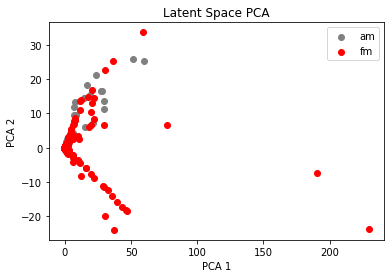

In [344]:
#@title Vizualización de datos
audio_viz = 'PCA' #@param ['PCA','F0', 'histogram']
fig, ax = plt.subplots()
if audio_viz == 'histogram':
  ax = DATA_filt['synth'].hist()
  ax.set_xlabel("Synth type")
  ax.set_ylabel(" # of observations")
  plt.show()
if audio_viz == 'F0':
  ax.plot(DATA_filt.index, DATA_filt['f0'], linestyle = '--')
  ax.set_xlabel("Audios")
  ax.set_ylabel(" F0")
  plt.show()
if audio_viz == 'PCA':
  pca = PCA(n_components= 2)
  X_PCA = pca.fit_transform(Xmu_FFT)
  print('variance: ')
  print(pca.explained_variance_ratio_)
  ax.scatter(X_PCA[0: indices2[0], 0], X_PCA[0: indices2[0], 1], c='gray', label = synth_names[0])
  ax.scatter(X_PCA[indices2[0]:, 0], X_PCA[indices2[0]:, 1], c='red', label = synth_names[1])
  fig.add_axes(ax)
  plt.legend()
  plt.title('Latent Space PCA')
  plt.xlabel('PCA 1')
  plt.ylabel('PCA 2')
  plt.show()


In [345]:
#@title Entrenamiento del modelo

##############preparacion de datos
data = np.vstack(DATA_filt['data'])
data.shape

mu_wave = np.mean(data, axis= 1)[...,np.newaxis]
max_wave = np.max(data, axis=1)[...,np.newaxis]

Xw = (data- mu_wave)#/max_wave
## para evitar la division entre ceros
Xw = np.divide(Xw, max_wave, out=np.zeros(Xw.shape, dtype=float), where=max_wave!=0)
print(Xw.shape)

Xw = Xw[...,np.newaxis][...,np.newaxis]
print(Xw.shape)

warm_up_iters = 1000 
optimizer = tf.keras.optimizers.Adam(0.000001)

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    #@tf.function
    def call(self, inputs):
        z_mean, z_log_var = inputs
        #z_mean = np.array([input[0]])
        #z_log_var = np.array([input[1]])
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon



class KLDivergenceRegularizer(tf.keras.regularizers.Regularizer):
  def __init__(self, iters: tf.Variable, warm_up_iters: int, latent_size: int):
    self._iters = np.array([iters])
    self._warm_up_iters = np.array([warm_up_iters])
    self.latent_size = latent_size
  
  @tf.function
  def __call__(self, activation):
    # note: activity regularizers automatically divide by batch size
    mu= activation[:self.latent_size]
    log_var = activation[self.latent_size:]
    k = np.min(self._iters / self._warm_up_iters)
    return -0.5 * k * K.sum(1+ log_var - K.square(mu) - K.exp(log_var))


latent_dim = 128
original_dim = (16000, 1, 1)
encoder_inputs = keras.Input(original_dim)                                                   # bat, samps, ?, ch
x = layers.Conv2D(64, (66,1), activation="relu", padding="same",strides=(4,1))(encoder_inputs) # [69, 48000, 1, 1] -> [69, 12000, 1, 64]
x = layers.Conv2D(128,(66,1), activation="relu", padding="same",strides=(4,1))(x)
x = layers.Conv2D(256,(66,1), activation="relu", padding="same",strides=(4,1))(x)
latent = layers.Conv2D(512,(66,1), activation="relu", padding="same",strides=(3,1))(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(units=latent_dim, name='Z-Mean')(x) # Mean component
z_log_sigma = layers.Dense(units=latent_dim, name='Z-Log-Sigma')(x) # Standard deviation component
#######que pasa con z_regular nunca se usa?
z_regular = tf.keras.layers.Concatenate(activity_regularizer= KLDivergenceRegularizer(optimizer.iterations, warm_up_iters,latent_dim))([z_mean,z_log_sigma])
z = Sampling()([z_mean, z_log_sigma])
#z = Sampling()(z_regular)
vae_encoder = keras.Model(encoder_inputs, [z_mean, z_log_sigma, z], name="encoder_vae")
#vae_encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(250 * 1 * 256, activation="relu")(latent_inputs)
x = layers.Reshape((250, 1, 256))(x)
#x = layers.Conv2DTranspose(512,(4,1), activation="relu",padding= "same",strides= (3,1))(x)
x = layers.Conv2DTranspose(128,(66,1), activation="relu",padding= "same",strides= (4,1))(x)
x = layers.Conv2DTranspose(64,(66,1), activation="relu",padding= "same",strides= (4,1))(x)
#x = layers.Conv2DTranspose(64,(16,1), activation="relu",padding= "same",strides=(4,1))(x)
decoder_outputs = layers.Conv2DTranspose(1, (66, 1), activation="tanh", padding="same", strides = (4,1))(x)
vae_decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder_vae")
#vae_decoder.summary()


# Define outputs from a VAE model by specifying how the encoder-decoder models are linked
outpt = vae_decoder(vae_encoder(encoder_inputs)[2]) # note, outputs available from encoder model are z_mean, z_log_sigma and z. We take z by specifying [2]
# Instantiate a VAE model
vae = Model(inputs=encoder_inputs, outputs=outpt, name='VAE-Model')
vae.compile(optimizer= optimizer,loss = 'mean_squared_error')

#vae.summary()

tr_logs = vae.fit(Xw, Xw, shuffle = True, batch_size= 5, epochs= 300)


(200, 16000)
(200, 16000, 1, 1)
Epoch 1/300
40/40 [==============================] - 67s 2s/step - loss: nan
Epoch 2/300
40/40 [==============================] - 65s 2s/step - loss: nan
Epoch 3/300
40/40 [==============================] - 66s 2s/step - loss: nan
Epoch 4/300
40/40 [==============================] - 65s 2s/step - loss: nan
Epoch 5/300
11/40 [=======>......................] - ETA: 47s - loss: nan

KeyboardInterrupt: ignored

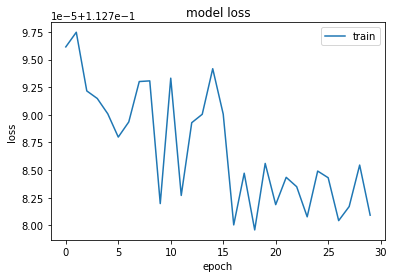

In [311]:
plt.plot(tr_logs.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [312]:
latent = vae_encoder.predict(Xw)
latent[0].shape

(21, 128)

variance: 
[0.2723003  0.11682871]


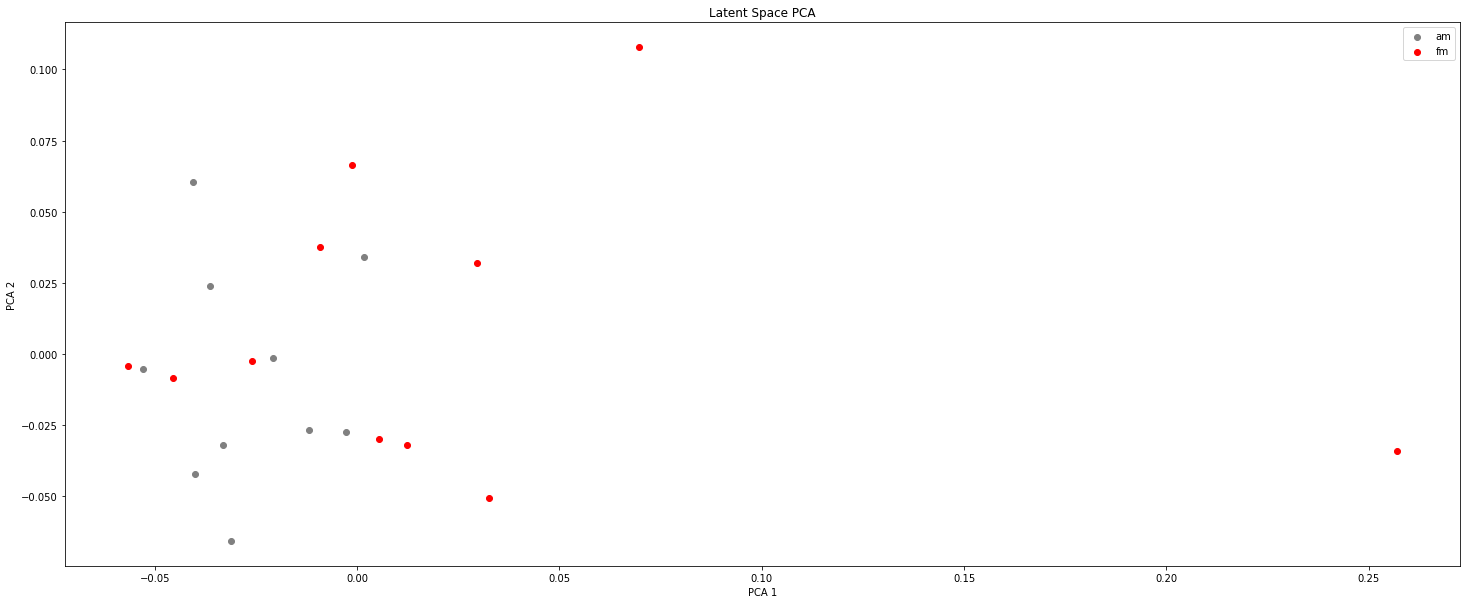

In [315]:
#@title Visualización del espacio latente


fig, ax = plt.subplots()
fig.set_figwidth(25)
fig.set_figheight(10)

# create the PCA instance with the number of components to be computed 
pca = PCA(n_components= 2)
X_PCA = pca.fit_transform(latent[0])
print('variance: ')
print(pca.explained_variance_ratio_)
ax.scatter(X_PCA[0: indices2[0], 0], X_PCA[0: indices2[0], 1], c='gray', label = synth_names[0])
ax.scatter(X_PCA[indices2[0]:, 0], X_PCA[indices2[0]:, 1], c='red', label = synth_names[1])
fig.add_axes(ax)
plt.legend()
plt.title('Latent Space PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
#plt.zlabel('PCA 3')

plt.show()


[0, 1, 2]


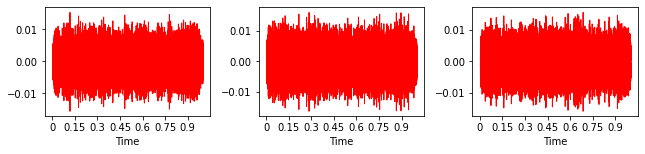

In [316]:
y_hat = vae.predict(Xw)
plt.figure(figsize=(15, 6))
sonidos = [i for i in range(3)]
print(sonidos)
for i, x in enumerate(sonidos):
    plt.subplot(3, 5, i+ 1)
    librosa.display.waveshow(y_hat[x].flatten(),16000, color='r')
plt.tight_layout()
plt.show()

In [ ]:
#@title Generación de Audios
Audio de referencia 1 = 'Vecinos euclidaneos' #@param ['Interpolación lineal','Vecinos euclidaneos']
Audio de referencia 2 = 'Vecinos euclidaneos' #@param ['Interpolación lineal','Vecinos euclidaneos']

tecnicas = 'Vecinos euclidaneos' #@param ['Interpolación lineal','Vecinos euclidaneos']

NameError: ignored

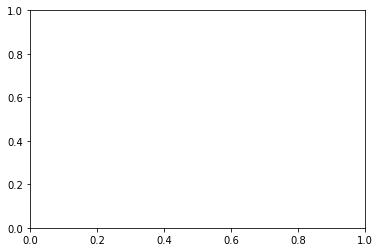

In [205]:
fig, ax = plt.subplots()
pca = PCA(n_components= 2)
X_PCA = pca.fit_transform(x)
ax.scatter(X_PCA[:len(res[0]), 0], X_PCA[:len(res[0]), 1], c = 'r')
ax.scatter(X_PCA[:len(res[1]), 0], X_PCA[:len(res[1]), 1], c = 'b')
print(pca.explained_variance_ratio_)
plt.show()

In [69]:
#@title Vizualización de datos

count = np.array(DATA['synth'].value_counts())
#filter_by = 'dataset' #@param ['dataset', 'f0']


a = widgets.IntRangeSlider(value= [30,20000], min = 20, max = 20000, description='f0')
d = widgets.Dropdown(
    options=['1', '2', '3'],
    value='2',
    description='Number:',
    disabled= False,
)

def f(p,q):
  return (p,q)

interact(f, p=5, q=fixed(20));

  print('hola')
b = widgets.IntSlider(value = count[0], max= count[0], description='b')
c = widgets.IntSlider(value = count[1], max= count[1], description='b')
widgets.HBox([widgets.VBox([a, b,c, d])])

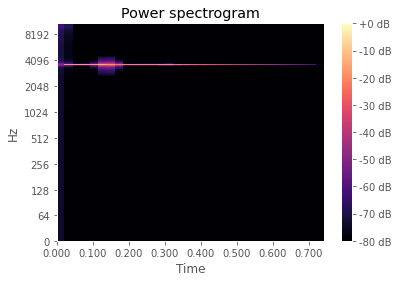

In [ ]:
DATA['fft'][0]

fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(DATA['fft'][3],
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")